In [1]:
%matplotlib inline
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

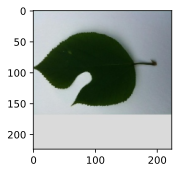

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../data/classify_leaves/images/23.jpg')
d2l.plt.imshow(img);

In [3]:
train_data = pd.read_csv('../data/classify_leaves/train.csv')

In [4]:
className = train_data['label'].value_counts()

In [5]:
lit  = list(range(0,train_data['label'].nunique()))
classValue = pd.Series(lit, index= className.index )

In [6]:
train_data['labelValue'] = classValue[train_data['label'].values].values
train_data

,image,label,labelValue
0,images/0.jpg,maclura_pomifera,0
1,images/1.jpg,maclura_pomifera,0
2,images/2.jpg,maclura_pomifera,0
3,images/3.jpg,maclura_pomifera,0
4,images/4.jpg,maclura_pomifera,0
...,...,...,...
18348,images/18348.jpg,aesculus_glabra,84
18349,images/18349.jpg,liquidambar_styraciflua,71
18350,images/18350.jpg,cedrus_libani,65
18351,images/18351.jpg,prunus_pensylvanica,120


整理数据集

In [7]:
data_dir = '..\data\classify_leaves'


def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'train.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))
labels

# 训练样本 : 18353
# 类别 : 176


{'images/0.jpg': 'maclura_pomifera',
 'images/1.jpg': 'maclura_pomifera',
 'images/2.jpg': 'maclura_pomifera',
 'images/3.jpg': 'maclura_pomifera',
 'images/4.jpg': 'maclura_pomifera',
 'images/5.jpg': 'maclura_pomifera',
 'images/6.jpg': 'ulmus_rubra',
 'images/7.jpg': 'broussonettia_papyrifera',
 'images/8.jpg': 'maclura_pomifera',
 'images/9.jpg': 'broussonettia_papyrifera',
 'images/10.jpg': 'maclura_pomifera',
 'images/11.jpg': 'prunus_virginiana',
 'images/12.jpg': 'maclura_pomifera',
 'images/13.jpg': 'prunus_virginiana',
 'images/14.jpg': 'broussonettia_papyrifera',
 'images/15.jpg': 'maclura_pomifera',
 'images/16.jpg': 'maclura_pomifera',
 'images/17.jpg': 'broussonettia_papyrifera',
 'images/18.jpg': 'maclura_pomifera',
 'images/19.jpg': 'ulmus_rubra',
 'images/20.jpg': 'maclura_pomifera',
 'images/21.jpg': 'maclura_pomifera',
 'images/22.jpg': 'prunus_virginiana',
 'images/23.jpg': 'broussonettia_papyrifera',
 'images/24.jpg': 'maclura_pomifera',
 'images/25.jpg': 'brousson

In [8]:
collections.Counter(labels.values()).most_common()[-1][1]

51

In [9]:
for train_file in os.listdir(os.path.join(data_dir, 'images')):
    print(train_file.split('.'))

['0', 'jpg']
['1', 'jpg']
['10', 'jpg']
['100', 'jpg']
['1000', 'jpg']
['10000', 'jpg']
['10001', 'jpg']
['10002', 'jpg']
['10003', 'jpg']
['10004', 'jpg']
['10005', 'jpg']
['10006', 'jpg']
['10007', 'jpg']
['10008', 'jpg']
['10009', 'jpg']
['1001', 'jpg']
['10010', 'jpg']
['10011', 'jpg']
['10012', 'jpg']
['10013', 'jpg']
['10014', 'jpg']
['10015', 'jpg']
['10016', 'jpg']
['10017', 'jpg']
['10018', 'jpg']
['10019', 'jpg']
['1002', 'jpg']
['10020', 'jpg']
['10021', 'jpg']
['10022', 'jpg']
['10023', 'jpg']
['10024', 'jpg']
['10025', 'jpg']
['10026', 'jpg']
['10027', 'jpg']
['10028', 'jpg']
['10029', 'jpg']
['1003', 'jpg']
['10030', 'jpg']
['10031', 'jpg']
['10032', 'jpg']
['10033', 'jpg']
['10034', 'jpg']
['10035', 'jpg']
['10036', 'jpg']
['10037', 'jpg']
['10038', 'jpg']
['10039', 'jpg']
['1004', 'jpg']
['10040', 'jpg']
['10041', 'jpg']
['10042', 'jpg']
['10043', 'jpg']
['10044', 'jpg']
['10045', 'jpg']
['10046', 'jpg']
['10047', 'jpg']
['10048', 'jpg']
['10049', 'jpg']
['1005', 'jpg']

In [10]:
#@save
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'images')):
        label = labels[ "images/" + train_file]
        fname = os.path.join(data_dir, 'images', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))    # 所有文件重新copy 到 train_valid_test/train_valid , 并分类存放在类别目录中   
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))      # 一定比例 valid_ratio 的文件 copy 到 train_valid_test/valid  ，并分类存放在类别目录中， 用于验证
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))      # 多数文件 copy 到 train_valid_test/train 目录，并分类存放在类别目录中， 用于训练
    return n_valid_per_label

In [11]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [12]:
def reorg_leaves_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'train.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [13]:
batch_size =  64
valid_ratio = 0.1
# reorg_leaves_data(data_dir, valid_ratio)

图像增广

In [14]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
     ])

In [15]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
    ])

读取数据数据集

In [16]:
data_dir2 = '..\data\kaggle_cifar10_tiny'
data_dir3 = '..\data\classify_leaves'

In [17]:
ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test','test'),
    transform=transform_train
    )



In [18]:
ds

Dataset ImageFolder
    Number of datapoints: 8800
    Root location: ..\data\classify_leaves\train_valid_test\test
    StandardTransform
Transform: Compose(
               Resize(size=40, interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(32, 32), scale=(0.64, 1.0), ratio=(1.0, 1.0), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [19]:
print(ds.classes)  #根据分的文件夹的名字来确定的类别
print(ds.class_to_idx) #按顺序为这些类别定义索引为0,1...


['unknown']
{'unknown': 0}


In [20]:
print(ds.imgs[0:10]) #返回从所有文件夹中得到的图片的路径以及其类别

[('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18353.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18354.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18355.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18356.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18357.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18358.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18359.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18360.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18361.jpg', 0), ('..\\data\\classify_leaves\\train_valid_test\\test\\unknown\\18362.jpg', 0)]


In [21]:
ds_iter = torch.utils.data.DataLoader( ds, 2, shuffle=True, drop_last=True)

In [22]:
k = 0
for imags in ds_iter:
    k +=1

k


4400

In [23]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

In [24]:

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [54]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

定义模型

残差块， 此代码生成两种类型的网络： 一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。 另一种是当use_1x1conv=True时，添加通过
卷积调整通道和分辨率。

In [26]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides =1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,num_channels,kernel_size=3, padding=1,stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3, padding=1,)
        self.bn2 = nn.BatchNorm2d(num_channels)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
    
    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)

        if self.conv3:
            X = self.conv3(X)
        Y += X
        
        Y = F.relu(Y)
        return Y
    

ResNet 模块

In [27]:
def resnet_block(input_channels, num_channels, num_residuals, first_block = False):
    blk = []
    for i in range(num_residuals):
        if i ==0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Residual Net

In [28]:
def residualNet( in_channels=1, num_classes =10):
    '''  
    b1 =nn.Sequential(nn.Conv2d(in_channels,64, kernel_size=7, stride=2, padding=3),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride= 2, padding=1)                  
                  )
    '''
    b1 =nn.Sequential(nn.Conv2d(in_channels,64, kernel_size=3, stride=1, padding=1),
                  nn.BatchNorm2d(64), nn.ReLU(),
                #  nn.MaxPool2d(kernel_size=3, stride= 2, padding=1)                  
                  )
    b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
    b3 = nn.Sequential(*resnet_block(64,128,2))
    b4 = nn.Sequential(*resnet_block(128,256,2))
    b5 = nn.Sequential(*resnet_block(256,512,2))
    net = nn.Sequential(b1, b2,b3,b4,b5, 
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(512,num_classes))
    return net

In [29]:
def get_net(input_channels, num_classes):
    net = residualNet(input_channels,num_classes)
   # net =  d2l.resnet18(num_classes, 3)
    return net



定义训练函数

In [30]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

train loss 0.339, train acc 0.886, valid acc 0.805
1458.6 examples/sec on [device(type='cuda', index=0)]


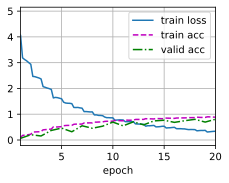

In [31]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay  = 4, 0.9

net = get_net(3,len(set(labels.values())))
loss = nn.CrossEntropyLoss(reduction="none")

train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

在 Kaggle 上对测试集进行分类并提交结果

train loss 0.335, train acc 0.890
1518.8 examples/sec on [device(type='cuda', index=0)]


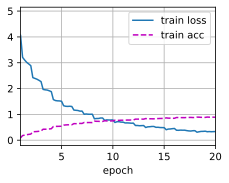

In [55]:
net, preds = get_net(3,len(set(labels.values()))), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
num_list = list(range(18353, 18353+len(test_ds)))
sorted_ids = [str(i) + '.jpg' for i in num_list ] 
#sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission01.csv', index=False)

train loss 0.345, train acc 0.886
1467.1 examples/sec on [device(type='cuda', index=0)]


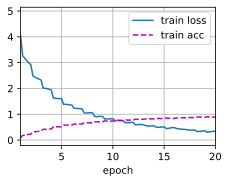

In [33]:
net, preds = get_net(3,len(set(labels.values()))), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)


In [34]:

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())


In [35]:
len(preds), preds

(8800,
 [22,
  29,
  120,
  106,
  120,
  74,
  162,
  91,
  165,
  95,
  142,
  145,
  135,
  35,
  105,
  91,
  101,
  143,
  45,
  58,
  65,
  92,
  44,
  133,
  69,
  77,
  10,
  114,
  144,
  29,
  84,
  63,
  32,
  147,
  83,
  53,
  82,
  6,
  100,
  0,
  153,
  77,
  161,
  111,
  163,
  174,
  32,
  9,
  108,
  48,
  21,
  58,
  152,
  110,
  148,
  37,
  76,
  8,
  59,
  165,
  80,
  175,
  137,
  144,
  32,
  69,
  171,
  130,
  80,
  166,
  124,
  118,
  36,
  30,
  170,
  58,
  11,
  62,
  142,
  110,
  102,
  112,
  124,
  148,
  168,
  144,
  155,
  143,
  119,
  114,
  33,
  37,
  157,
  5,
  166,
  139,
  0,
  52,
  37,
  160,
  107,
  157,
  138,
  82,
  50,
  82,
  55,
  70,
  104,
  48,
  7,
  122,
  55,
  155,
  72,
  56,
  66,
  88,
  122,
  17,
  79,
  131,
  161,
  164,
  130,
  156,
  82,
  110,
  73,
  124,
  158,
  140,
  59,
  65,
  163,
  55,
  120,
  37,
  158,
  149,
  39,
  58,
  172,
  159,
  73,
  77,
  78,
  78,
  83,
  50,
  97,
  52,
  160,
  74,
  

In [49]:
num_list = list(range(18353, 18353+len(test_ds)))

sorted_ids = [str(i) + '.jpg' for i in num_list ] 
len(sorted_ids), sorted_ids

(8800,
 ['18353.jpg',
  '18354.jpg',
  '18355.jpg',
  '18356.jpg',
  '18357.jpg',
  '18358.jpg',
  '18359.jpg',
  '18360.jpg',
  '18361.jpg',
  '18362.jpg',
  '18363.jpg',
  '18364.jpg',
  '18365.jpg',
  '18366.jpg',
  '18367.jpg',
  '18368.jpg',
  '18369.jpg',
  '18370.jpg',
  '18371.jpg',
  '18372.jpg',
  '18373.jpg',
  '18374.jpg',
  '18375.jpg',
  '18376.jpg',
  '18377.jpg',
  '18378.jpg',
  '18379.jpg',
  '18380.jpg',
  '18381.jpg',
  '18382.jpg',
  '18383.jpg',
  '18384.jpg',
  '18385.jpg',
  '18386.jpg',
  '18387.jpg',
  '18388.jpg',
  '18389.jpg',
  '18390.jpg',
  '18391.jpg',
  '18392.jpg',
  '18393.jpg',
  '18394.jpg',
  '18395.jpg',
  '18396.jpg',
  '18397.jpg',
  '18398.jpg',
  '18399.jpg',
  '18400.jpg',
  '18401.jpg',
  '18402.jpg',
  '18403.jpg',
  '18404.jpg',
  '18405.jpg',
  '18406.jpg',
  '18407.jpg',
  '18408.jpg',
  '18409.jpg',
  '18410.jpg',
  '18411.jpg',
  '18412.jpg',
  '18413.jpg',
  '18414.jpg',
  '18415.jpg',
  '18416.jpg',
  '18417.jpg',
  '18418.jpg',
  '

In [50]:
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df

,id,label
0,18353.jpg,22
1,18354.jpg,29
2,18355.jpg,120
3,18356.jpg,106
4,18357.jpg,120
...,...,...
8795,27148.jpg,119
8796,27149.jpg,144
8797,27150.jpg,110
8798,27151.jpg,135


In [51]:

df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission02.csv', index=False)

In [52]:
df[5:14]

,id,label
5,18358.jpg,koelreuteria_paniculata
6,18359.jpg,styrax_japonica
7,18360.jpg,metasequoia_glyptostroboides
8,18361.jpg,tilia_cordata
9,18362.jpg,ostrya_virginiana
10,18363.jpg,quercus_marilandica
11,18364.jpg,quercus_muehlenbergii
12,18365.jpg,quercus_acutissima
13,18366.jpg,castanea_dentata
